In [17]:
import cv2
import commonfunctions as cf
import numpy as np
import matplotlib.pyplot as plt
from numba import njit,prange
# import nbimporter
# from count_rows import count_rows

img shape: (93, 515), max=255, min=0,median=255.0 and type uint8
tolerance: 25.75


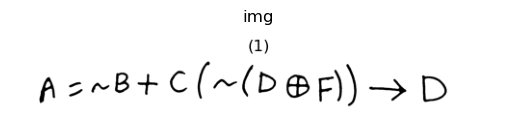

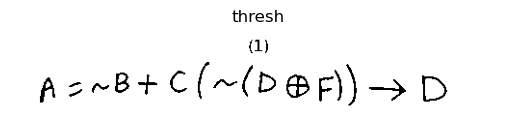

contours before area filtering
49.5, -34.5, -53.5, -31.5, 81.5, 41.0, -16.0, 218.0, 94.0, -312.5, -24.0, 218.5, 167.0, -36.5, 570.0, -115.5, 469.0, 132.5, -38.0, 270.0, 298.5, 142.5, 112.5, 119.0, 155.0, 135.5, 33.5, 37.0, 55.0, 2.0, -47288.0, 
average_area 161.97619047619048
max_width 40
max_height 45
contours after area filtering
504, 105, 160, 240, 391, 506, 500, 560, 297, 455, 90, 140, 480, 80, 676, 476, 340, 585, 960, 812, 
masks


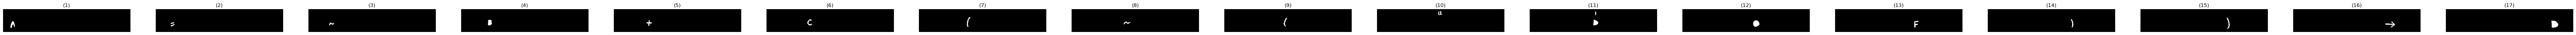

contours after merging


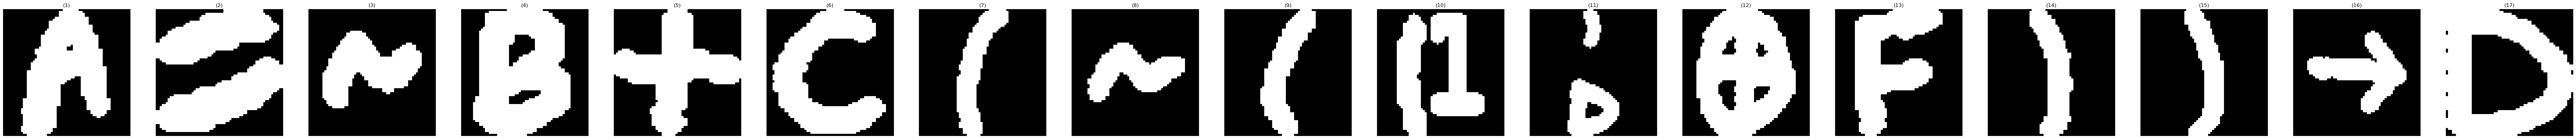

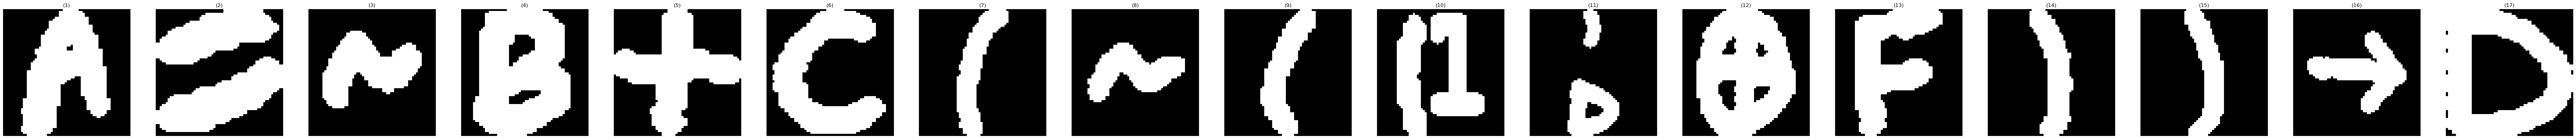

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
# Load the image
def get_letters(img, verbose = False,single_letter = False):
    # convert to grayscale
    # img = cv2.resize(img, (0,0),fx=0.5, fy=0.5)
    h,w = img.shape
    retSize = (64,64)
    
    tolerance = 0.05 * w 
    if verbose:
        print(f'img shape: {img.shape}, max={img.max()}, min={img.min()},median={np.median(img)} and type {img.dtype}')
        print(f'tolerance: {tolerance}')
        
        cf.show_images([img],['img'])
    
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    
    if verbose:
        cf.show_images([thresh],['thresh'])
    # Find the contours
    contours,_ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if verbose:
        print('contours before area filtering')
        for cnt in contours:
            print(cv2.contourArea(cnt,True),end=', ')
        print()
    
    average_area = 0.0   
    max_area = 0.0   
    max_width  = 0.0  
    max_height  = 0.0 
    average_width  = 0.0  
    average_height  = 0.0 
    
    # only keep the contours that are black  and i needed to discard the small parts
    contours = list(filter(lambda cnt: cv2.contourArea(cnt,True) > 0, contours))
    contours_list = [[box,c] for box,c in [(cv2.boundingRect(c),c) for c in contours]]
    contours_list = sorted(contours_list, key=lambda ctr:ctr[0])
    
    if len(contours_list) != 0:
        average_area   = sum([ cv2.contourArea(cnt[1]) for cnt in contours_list]) / len(contours_list)
        max_area   = max([cv2.contourArea(cnt[1]) for cnt in contours_list])
        max_width  = max( [ cnt[0][2] for cnt in contours_list]) 
        max_height = max([ cnt[0][3] for cnt in contours_list])
        average_width = sum([cnt[0][2] for cnt in contours_list]) / len(contours_list)
        average_height = sum([cnt[0][3] for cnt in contours_list]) / len(contours_list)
    
    if(verbose):
        print('average_area',average_area)
        print('max_width',max_width)
        print('max_height',max_height)
    # only keep the contours that are black  and i needed to discard the small parts
    # x,y,w,h 
    
    def filter_contours(cnt):
        (x,y,w,h),q = cnt
        # filter contours that are too small
        return  cv2.contourArea(q) >= max_area * 0.9 if single_letter else cv2.contourArea(q) > average_area * 0.1 # and  w > max_width * 0.25 
    contours_list = list(filter(filter_contours, contours_list))
    
    if verbose:
        print('contours after area filtering')
        for cnt in contours_list:
            print(cnt[0][2] * cnt[0][3],end=', ')
        print()
    # sort contours from left to right

    # max_height =sorted(contours_list, key=lambda ctr: ctr[3])[-1][3]
    # max_width =sorted(contours_list, key=lambda ctr: ctr[2])[-1][2]
    
    # # print("maxxxxxxxx",max_height)
    # height_margin = max_height // 10
    # width_margin = max_width // 15
    
    # put masks on the image to get the each letter individually
    masks = []
    for cont in contours_list:
        mask = np.zeros(img.shape, np.float32)
        cv2.drawContours(mask, [cont[1]], 0, (1,1,1),-1)
        masks.append(mask)
        
    #sort contours from left to right
    # contours_list = sorted(contours_list, key=lambda ctr: ctr[0])3


    # merge list that are too close in x axis
    
    def union(a,b):
        '''
        union of two BoxRectangles 
        '''
        x = min(a[0], b[0])
        y = min(a[1], b[1])
        w = max(a[0]+a[2], b[0]+b[2]) - x
        h = max(a[1]+a[3], b[1]+b[3]) - y
        return (x, y, w, h)

    for ind,(box,_) in enumerate(contours_list):
        x,y,w,h = box
        prev_x = float('-inf') if ind == 0 else contours_list[ind-1][0][0]   
        prev_h = float('-inf') if ind == 0 else contours_list[ind-1][0][3]   
        if (x - prev_x < max_width *0.2 and abs(h - prev_h) < max_height * 0.2):
            # merge contours 
            contours_list[ind] = (union(contours_list[ind][0],contours_list[ind-1][0]),contours_list[ind][1])
            contours_list.pop(ind-1)
            # merge masks of the letters
            masks[ind] = masks[ind] + masks[ind-1]
            masks.pop(ind-1)
            ind -=1
            
    if verbose:
        print('masks')
        cf.show_images(masks)
        
        
        
    # For each contour, find the bounding rectangle and draw it
    ret_images = []
    for ind,(box,_) in enumerate(contours_list):
        # print(box)
        x,y,w,h = tuple(box)
        new_img  = np.logical_and( ~img, masks[ind])[y:y+h, x:x+w].astype(np.uint8)
        pad_h = int(h * 0.02)
        pad_w = int(w * 0.2)
        if h > w :
            pad_w = (h-w)//2
        else :
            pad_h = (w-h)//2
        new_img = np.pad(new_img, ((pad_h,pad_h),(pad_w,pad_w)), 'constant')
        ret_images.append(new_img)
        if verbose:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1) #crop 
            # cv2.putText(img, str(ind), (x,y), cv2.FONT_ITALIC, 1, (0,0,255), 2, cv2.LINE_AA)
    
    
    if verbose:
        print('contours after merging')
        plt.show()
        
 
    for i in range(len(ret_images)):
        if(ret_images[i].shape != (0,0)):
            ret_images[i] = cv2.resize(ret_images[i], retSize)
            ret_images[i] = cv2.morphologyEx(ret_images[i], cv2.MORPH_DILATE, cv2.getStructuringElement(shape= cv2.MORPH_ELLIPSE, ksize= (5,5)))#, iterations=1)
        
    if verbose:
        cf.show_images(ret_images)
        
    if(len(ret_images) == 0):
        return [cv2.resize(img.max()-img, retSize)]
    
    
    
    return ret_images
    


# from skimage.morphology import skeletonize

img =  cv2.cvtColor(cv2.imread("./test_images/wowow.png"), cv2.COLOR_BGR2GRAY)

# # # apply skeletonization 
# # # perform skeletonization
letters = get_letters(img,verbose=True)

# # skeleton = skeletonize(letters[0])
cf.show_images(letters)

# letter = cv2.cvtColor(cv2.imread('./datasets/Img/img005-047.png'), cv2.COLOR_BGR2GRAY)
# # draw histogram 


# cf.show_images(get_letters(letter,verbose=True))

# img =  cv2.cvtColor(cv2.imread(r"D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\symbols\0\0_517.jpg"), cv2.COLOR_BGR2GRAY)
# letters = get_letters(img,verbose=True, single_letter=True)
# cf.show_images(letters, )
# # skeleton = skeletonize(letters[0])
# # cf.show_images([skeleton],['skeleton'])

In [19]:
# import os
# from os import listdir

# dataset = []
# #load dataset
# folder_dir = r"./datasets/symbols/eval/plus val/"
# for image in os.listdir(folder_dir):
#     dataset.append(cv2.cvtColor(cv2.imread(folder_dir+'/'+image), cv2.COLOR_BGR2GRAY))
    
    
# # get the letters from the dataset
# letters = []
# for img in dataset:
#     letters.append(get_letters(img,single_letter=True))

# count = 0
# # write the letters to the disk
# for i in range(len(letters)):
#     if(len(letters[i]) >1):
#         count +=1
#     for j in range(len(letters[i])):
#         cv2.imwrite('./datasets/letters/'+str(i)+'-'+str(j)+'.png',(1- letters[i][j])*255)
        

In [20]:


import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
from sklearn import *
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin

from sklearn.metrics import accuracy_score




In [21]:
# #importing required libraries
# from skimage.io import imread, imshow
# from skimage.transform import resize
# from skimage.feature import hog
# from skimage import exposure
# import matplotlib.pyplot as plt
# %matplotlib inline


# #reading the image
# # img = imread(r"D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\symbols\!\!_7928.jpg")
# # imshow(img)
# # print(img.shape)

# def hog_func(img):
#     #resizing image 
#     resized_img = resize(img, (128,64)) 
#     # imshow(resized_img) 
#     # print(resized_img.shape)

#     #creating hog features 
#     fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
#                         cells_per_block=(2, 2), visualize=True)
    
#     return fd

